In [1]:
from IPython.display import clear_output

import os
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from custom_utils import *
from models import *

import sys
sys.path.insert(1, './stylegan2-ada-pytorch')

import dnnlib
import legacy
from torch_utils import misc

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
with open('overfit_sample_embeddings_secondrun.npy', 'rb') as f:
    overfit_embeddings = np.load(f)

dataset_path = '/projectnb/cs585bp/585-Project-nguymi01/data/'
attr_data = pd.read_csv(os.path.join(dataset_path, 'list_attr_celeba.csv'))

_all_fnames = [
    os.path.relpath(os.path.join(root, fname), start=dataset_path) 
    for root, _dirs, files in os.walk(dataset_path) for fname in files
]
    
_image_fnames = sorted(fname for fname in _all_fnames if os.path.splitext(fname)[-1].lower() == '.jpg')
_image_fnames = _image_fnames[:overfit_embeddings.shape[0]]

attr_data = attr_data[attr_data.image_id.isin([elem.split('/')[-1] for elem in _image_fnames])]

labels = (attr_data.values[:, 1:].astype(int) + 1)//2

In [4]:
_image_fnames = [os.path.join(dataset_path, _fname) for _fname in _image_fnames]

In [6]:
class TrainEncoder():
    def __init__(
        self,
        network_pkl = './training-runs/00000--auto1-noaug-resumeffhq256/network-snapshot-000120.pkl',
        encoder_path = None,
        *,
        w_avg_samples              = 10000,
        initial_learning_rate      = .005,
        initial_noise_factor       = 0.05,
        lr_rampdown_length         = 0.25,
        lr_rampup_length           = 0.05,
        noise_ramp_length          = 0.75,
        regularize_noise_weight    = 1e5,
        verbose                    = False,
        device: torch.device
    ):
        
        print(f'Loading networks from "{network_pkl}"...')
        with dnnlib.util.open_url(network_pkl) as fp:
            self.G = legacy.load_network_pkl(fp)['G_ema'].eval().requires_grad_(False).to(device) # type: ignore

        self.encoder = VGG16_Encoder(z_dim=self.G.z_dim)
        if encoder_path is not None:
            print(f'Loading encoder from "{encoder_path}"...')
            self.encoder.load_state_dict(torch.load(encoder_path), strict=False)
        self.encoder = self.encoder.to(device).train()
                    
        self.w_avg_samples  = w_avg_samples
        self.verbose        = verbose
        self.device         = device
        
        self.initial_learning_rate  =initial_learning_rate
        self.initial_noise_factor   =initial_noise_factor
        self.lr_rampdown_length     =lr_rampdown_length
        self.lr_rampup_length       =lr_rampup_length
        self.noise_ramp_length      =noise_ramp_length
        self.regularize_noise_weight=regularize_noise_weight
        
        # Compute w stats.
        self.compute_wstats()
        
    def compute_wstats(self):
        self.logprint(f'Computing W midpoint and stddev using {self.w_avg_samples} samples...')
        z_samples = np.random.RandomState(123).randn(self.w_avg_samples, self.G.z_dim)
        w_samples = self.G.mapping(torch.from_numpy(z_samples).to(self.device), None)  # [N, L, C]
        w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)       # [N, 1, C]
        self.w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 1, C]
        self.w_std = (np.sum((w_samples - self.w_avg) ** 2) / self.w_avg_samples) ** 0.5
        
    def logprint(self, *args):
            if self.verbose:
                print(*args)
    
    def training(
        self,
        _image_fnames,
        w_opt,
        target_size = 4,
        batch_size = 16,
        num_epoch = 1024,
        mode='random'
    ):
        self.show_test()
        scaler = torch.cuda.amp.GradScaler()

        emergency_stop = False
        repeat_inds = np.arange(target_size)[:, np.newaxis].repeat(batch_size//target_size, 1).T.flatten()
       
        # Setup noise inputs.
        noise_bufs = { name: buf for (name, buf) in self.G.synthesis.named_buffers() if 'noise_const' in name }
        
        params = [p for p in self.encoder.parameters() if p.requires_grad]
        optimizer = torch.optim.AdamW(params + list(noise_bufs.values()),
                                      betas=(0.9, 0.999), lr=self.initial_learning_rate)

        # Init noise.
        for buf in noise_bufs.values():
            buf.requires_grad = False
            buf[:] = torch.randn_like(buf)
            buf.requires_grad = True

        for epoch in tqdm(range(num_epoch)):
            # Learning rate schedule.
            t = epoch / num_epoch
            w_noise_scale = self.w_std * self.initial_noise_factor * max(0.0, 1.0 - t / self.noise_ramp_length) ** 2
            lr_ramp = min(1.0, (1.0 - t) / self.lr_rampdown_length)
            lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
            lr_ramp = lr_ramp * min(1.0, t / self.lr_rampup_length)
            lr = self.initial_learning_rate * lr_ramp
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

            BSTEPS = range(w_opt.shape[0] // batch_size)
            if mode == 'random':
                BSTEPS = range(1)
            for batch_num in tqdm(BSTEPS):
                #torch.cuda.empty_cache()
                # setup target embeddings
                
                if mode == 'random':
                    z_samples = np.random.RandomState(epoch+batch_num).randn(batch_size, trainer.G.z_dim)
                    w_samples = trainer.G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
                    target_embeddings = w_samples.mean(1)
                    
                #elif mode == 'use_image':
                else:
                    z_samples = np.random.RandomState(epoch+batch_num).randn(batch_size//2, trainer.G.z_dim)
                    w_samples = trainer.G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
                                        
                    target_embeddings = w_opt[target_size*batch_num:target_size*(batch_num+1)]
                    randinds = np.random.choice(target_size, batch_size//2)
                    mask = np.random.rand(batch_size//2, target_embeddings.shape[1]) > 0.25
                    randinds[:target_size] = np.arange(target_size)
                    target_embeddings = (
                        mask * target_embeddings[repeat_inds][:batch_size//2] +
                        ~mask * target_embeddings[randinds]
                    )
                    target_embeddings = torch.from_numpy(target_embeddings).to(device)
                    target_embeddings = torch.cat([target_embeddings, w_samples.mean(1)], 0)
                    
#                 else:
#                     target_embeddings = w_opt[target_size*batch_num:target_size*(batch_num+1)]
#                     randinds = np.random.choice(target_size, batch_size)
#                     mask = np.random.rand(batch_size, target_embeddings.shape[1]) > 0.25
#                     mask[:target_size]=True
#                     randinds[:target_size] = np.arange(target_size)
#                     target_embeddings = (
#                         mask * target_embeddings[repeat_inds] +
#                         ~mask * target_embeddings[randinds]
#                     )
#                     target_embeddings = torch.from_numpy(target_embeddings).to(device)

                if mode == 'use_image':
                    # load target images
                    target_images = load_image_batch(_image_fnames, batch_size=target_size, batch_num=batch_num)
                    target_images = torch.tensor(target_images.transpose([0, 3, 1, 2]), device=device).to(torch.float)
                    target_mean = target_images.mean((-1,-2)).view(*target_images.shape[:2], 1,1)
                    target_std =  target_images.std((-1,-2)).view(*target_images.shape[:2], 1,1)
                    target_normed = (target_images - target_mean) / (target_std + 1e-6)

                # add noise to the target_embeddings
                noise = torch.randn_like(target_embeddings) * w_noise_scale
                ws = (target_embeddings + noise).unsqueeze(1).repeat([1, self.G.mapping.num_ws, 1])
                                
                # reconstruct target embeddings
                reconst_embeddings = self.encoder(
                    (self.G.synthesis(ws, noise_mode='const') + 1) * (255/2)
                )
                
                dist = []
                dist.append(nn.functional.mse_loss(reconst_embeddings, target_embeddings))
                dist.append(nn.functional.l1_loss(reconst_embeddings, target_embeddings))
                logstr=f' MSE_emb:{dist[0]:<4.4f} L1_emb: {dist[1]:<4.4f}'
                if mode == 'use_image':
                    # reconstruct target images
                    synth_images = self.G.synthesis(
                        self.encoder(target_images).unsqueeze(1).repeat([1, self.G.mapping.num_ws, 1]),
                        noise_mode='const'
                    )
                    synth_images = (synth_images + 1) * (255/2)
                    synth_normed = (synth_images - target_mean) / (target_std + 1e-6)
                
                    show_image_ongrid(target_images.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().detach().numpy())
                    show_image_ongrid(synth_images.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().detach().numpy())
                    
                    dist.append(nn.functional.mse_loss(synth_images, target_images))
                    dist.append(nn.functional.l1_loss(synth_images, target_images))
                    
                    dist.append(nn.functional.mse_loss(synth_normed, target_normed))
                    dist.append(nn.functional.l1_loss(synth_normed, target_normed))
                    logstr+=f' MSE_img:{dist[2]:<4.4f} L1_img: {dist[3]:<4.4f}'
                    logstr+=f' MSE_imgr:{dist[4]:<4.4f} L1_imgr: {dist[5]:<4.4f}'
                    
                self.logprint(logstr)

                # Noise regularization.
                reg_loss = 0.0
                for v in noise_bufs.values():
                    noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
                    while True:
                        reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                        reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                        if noise.shape[2] <= 8:
                            break
                        noise = nn.functional.avg_pool2d(noise, kernel_size=2)
                loss = torch.stack(dist).sum() + reg_loss * self.regularize_noise_weight
                
                if loss.isnan():
                    print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! NAN loss')
                    print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! NAN loss')
                    print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! NAN loss')
                    emergency_stop = True
                    break

                # Step
                
                gb = min(1e1, 1/lr_ramp)
                print(gb)
                
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                nn.utils.clip_grad_value_(params + list(noise_bufs.values()), clip_value=gb)
                
                for i in range(len(params)):
                    if params[i].grad is not None:
                        misc.nan_to_num(params[i].grad, nan=0, posinf=gb, neginf=-1.*gb, out=params[i].grad)
                
                scaler.step(optimizer)
                scaler.update()
                
                logstr+=f'\nepoch {epoch}\tstep {batch_num+1:>4d}/{w_opt.shape[0] // batch_size}: dist {torch.stack(dist).sum():<4.4f} loss {float(loss):<5.4f}'
                self.logprint(logstr)

                # Normalize noise.
                with torch.no_grad():
                    for buf in noise_bufs.values():
                        buf -= buf.mean()
                        buf *= buf.square().mean().rsqrt()
                        
            if emergency_stop:
                break
                
            clear_output(wait=True)
            
            if mode != 'random':
                self.show_test()
                self.save()

    def save(self):
        torch.save(self.encoder.state_dict(), './training-runs/encoder_synth.sdict')
        
    def show_test(self):
        target_images = load_image_batch(_image_fnames, batch_size=4, batch_num=0)
        target_images = torch.tensor(target_images.transpose([0, 3, 1, 2]), device=device, requires_grad=False).to(torch.float)

        synth_images = self.G.synthesis(
            self.encoder(target_images).unsqueeze(1).repeat([1, self.G.mapping.num_ws, 1]),
            noise_mode='const'
        )
        synth_images = (synth_images + 1) * (255/2)
        
        show_image_ongrid(target_images.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().detach().numpy())
        show_image_ongrid(synth_images.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().detach().numpy())
            

Loading networks from "./training-runs/00001--auto1-noaug-resumecustom/network-snapshot-000120.pkl"...
Loading encoder from "./training-runs/encoder_synth.sdict"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


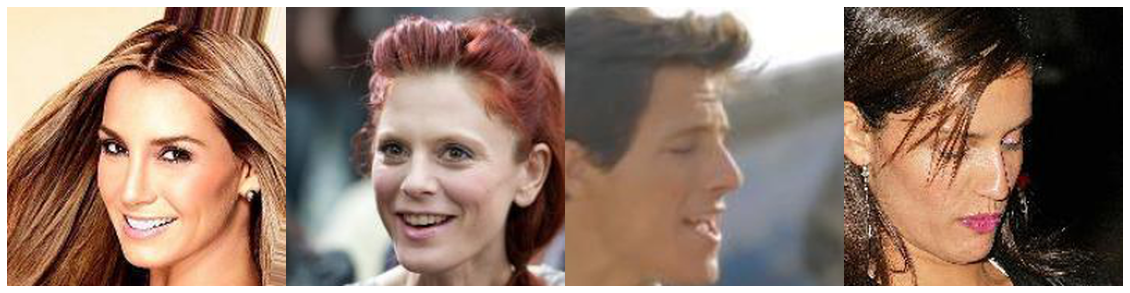

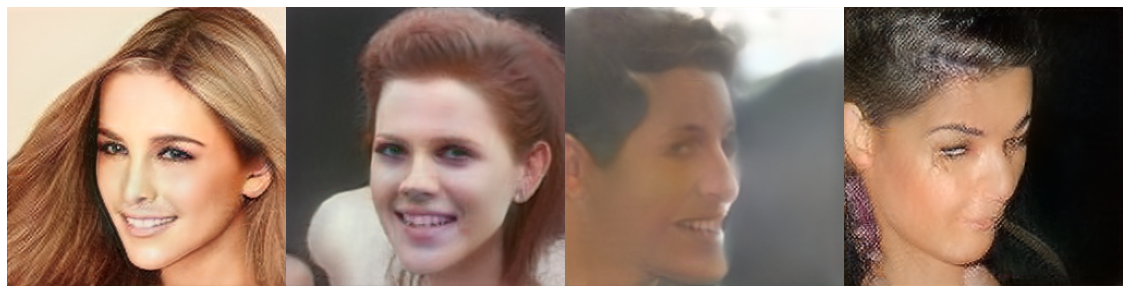

In [7]:
device = torch.device('cuda')
network_pkl = './training-runs/00001--auto1-noaug-resumecustom/network-snapshot-000120.pkl'
encoder_path = './training-runs/encoder_synth.sdict'
trainer = TrainEncoder(
    network_pkl=network_pkl,
    encoder_path=encoder_path,
    device=device,
    verbose=True
)
trainer.show_test()